# Imports

data sources: https://github.com/CSSEGISandData/COVID-19_Unified-Dataset documentation: https://github.com/OxCGRT/covid-policy-tracker/blob/master/documentation/codebook.md

In [7]:
import datetime
import pandas as pd
import numpy as np
import pyreadr
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import callbacks

# TODO: model db with 30 features

## Deltas

In [8]:
lma_baseline=pd.read_csv('C:/Users/User/code/TristanBOOK/coronanet/coronanet/data/LMA_relative_time_cases.csv')
lma_baseline['Cases']=lma_baseline['Cases'].astype(float)
lma_baseline=lma_baseline.drop('Unnamed: 0',axis=1)

J_14=(lma_baseline['Cases']/lma_baseline['J-14'])**(1/13)
J14=(lma_baseline['J14']/lma_baseline['Cases'])**(1/13)
J7=(lma_baseline['J7']/lma_baseline['Cases'])**(1/6)
J21=(lma_baseline['J21']/lma_baseline['Cases'])**(1/20)

lma_baseline['Delta7']=(J7/J_14)
lma_baseline['Delta14']=(J14/J_14)
lma_baseline['Delta21']=(J21/J_14)

In [9]:
delta_30=lma_baseline[['Date','ID','Policy','Delta7','Delta14','Delta21']]
delta_30['Country']=delta_30['ID']
delta_30.set_index('Date',inplace=True)

c:\users\user\.venvs\lewagon\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [10]:
delta_30.head()

,ID,Policy,Delta7,Delta14,Delta21,Country
Date,,,,,,
2020-01-26,CN,C1,NaN,NaN,NaN,CN
2020-01-26,CN,C2,NaN,NaN,NaN,CN
2020-01-22,CN,C3,NaN,NaN,NaN,CN
2020-01-22,CN,C4,NaN,NaN,NaN,CN
2020-01-23,CN,C5,NaN,NaN,NaN,CN


## 30 features db

In [13]:
policies= pyreadr.read_r('C:/Users/User/Documents/le wagon project/Policy.RData')
policies_df = pd.DataFrame(policies['Policy'])
p_df=policies_df
p_df=p_df.rename(columns={"ID": "Country"})
clean_df=p_df[p_df['PolicyType']=='C1'][["Country","Date"]]
col_names=list(p_df.PolicyType.unique())

for c in col_names:
    clean_df[c]=p_df[p_df['PolicyType']==c].PolicyValue.values

clean_df=clean_df.drop("ID",axis=1)
clean_df=clean_df.drop("IC",axis=1)
clean_df=clean_df.rename(columns={"Country": "ID"})
clean_df.set_index('Date',inplace=True)

In [14]:
clean_df.head()

,ID,C1,C2,C3,C4,C5,C6,C7,C8,E1,...,I1D,I2,I2D,I3,I3D,I4,I4D,I4L,I4LD,M1
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,AD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2020-01-02,AD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2020-01-03,AD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2020-01-04,AD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2020-01-05,AD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


## Merge db

In [15]:
df=clean_df
df=df.merge(delta_30,on=['Date','ID'],how='right')

In [16]:
df

,ID,C1,C2,C3,C4,C5,C6,C7,C8,E1,...,I4,I4D,I4L,I4LD,M1,Policy,Delta7,Delta14,Delta21,Country
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-26,CN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,C1,NaN,NaN,NaN,CN
2020-01-26,CN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,C2,NaN,NaN,NaN,CN
2020-01-22,CN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,C3,NaN,NaN,NaN,CN
2020-01-22,CN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,C4,NaN,NaN,NaN,CN
2020-01-23,CN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,C5,NaN,NaN,NaN,CN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-25,SM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,H1,NaN,NaN,NaN,SM
2020-02-27,SM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,H2,NaN,NaN,NaN,SM
2020-02-27,SM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,H3,NaN,NaN,NaN,SM


In [17]:
d=df[['ID','Policy','Delta7','Delta14','Delta21']]
f=d.dropna()
f=f[f['Delta7']>0]
f=f[f['Delta7']!=1]
f=f[f['Delta7']<100]
ts=f
dum=pd.get_dummies(ts.Policy)
train_set=dum.merge(f, on='Date')

In [18]:
X=train_set.drop(['Policy','Delta7','Delta14','Delta21','ID'],axis=1)
X.reset_index(drop=True, inplace=True)

In [20]:
X=train_set[]

SyntaxError: invalid syntax (<ipython-input-20-c51246258416>, line 1)

# model db with 125 features

In [21]:
dataR= pyreadr.read_r('C:/Users/User/Documents/le wagon project/Policy.RData')

In [22]:
dataR

OrderedDict([('Policy',
                       ID        Date PolicyType  PolicyValue PolicyFlag PolicyNotes  \
              0        AD  2020-01-01         C1         0.00        NaN         NaN   
              1        AD  2020-01-01         C2         0.00        NaN         NaN   
              2        AD  2020-01-01         C3         0.00        NaN         NaN   
              3        AD  2020-01-01         C4         0.00        NaN         NaN   
              4        AD  2020-01-01         C5         0.00        NaN         NaN   
              ...      ..         ...        ...          ...        ...         ...   
              2793095  ZW  2020-12-05        I4L          NaN        NaN         NaN   
              2793096  ZW  2020-12-05       I4LD        73.81        NaN         NaN   
              2793097  ZW  2020-12-05         IC          NaN        NaN         NaN   
              2793098  ZW  2020-12-05         ID          NaN        NaN         NaN   
        

In [24]:
cases_df = pd.DataFrame(dataR['Policy'])
cases_df.head()

,ID,Date,PolicyType,PolicyValue,PolicyFlag,PolicyNotes,PolicySource
0,AD,2020-01-01,C1,0.0,NaN,NaN,OxCGRT
1,AD,2020-01-01,C2,0.0,NaN,NaN,OxCGRT
2,AD,2020-01-01,C3,0.0,NaN,NaN,OxCGRT
3,AD,2020-01-01,C4,0.0,NaN,NaN,OxCGRT
4,AD,2020-01-01,C5,0.0,NaN,NaN,OxCGRT


In [25]:
data_lma=pd.read_csv('https://raw.githubusercontent.com/TristanBOOK/coronanet/master/coronanet/data/LMA_Data_10_semaines_and_Pol_fam.csv')

In [26]:
data_lma.head()

,ID,Date,PolicyFamily,PolicyType,value,Cases,Cases_New,Type,Source,J-28,J-21,J-14,J-7,J0,J7,J14,J21,J28,J35,J42
0,AD,2020-02-27,E,E3_diff,141399008,0.0,0.0,Deaths,JHU,0,0,0,0,0,0,0,0,3,15,25
1,AD,2020-02-28,E,E3_diff,-141399008,0.0,0.0,Deaths,JHU,0,0,0,0,0,0,0,0,3,16,26
2,AD,2020-03-02,H,H2_diff,1,0.0,0.0,Deaths,JHU,0,0,0,0,0,0,0,1,8,21,29
3,AD,2020-03-11,H,H6_diff,2,0.0,0.0,Deaths,JHU,0,0,0,0,0,0,1,14,23,33,37
4,AD,2020-03-13,C,C3_diff,1,0.0,0.0,Deaths,JHU,0,0,0,0,0,0,3,16,26,35,40


## Policies DF

In [27]:
policies= dataR
policies_df = pd.DataFrame(policies['Policy'])
policies_df = policies_df.rename(columns={"ID": "Country"})

In [28]:
policies_df.head()

,Country,Date,PolicyType,PolicyValue,PolicyFlag,PolicyNotes,PolicySource
0,AD,2020-01-01,C1,0.0,NaN,NaN,OxCGRT
1,AD,2020-01-01,C2,0.0,NaN,NaN,OxCGRT
2,AD,2020-01-01,C3,0.0,NaN,NaN,OxCGRT
3,AD,2020-01-01,C4,0.0,NaN,NaN,OxCGRT
4,AD,2020-01-01,C5,0.0,NaN,NaN,OxCGRT


In [29]:
policies_df.set_index('PolicyType',inplace=True)
policies_df=policies_df.drop("I1",axis=0)
policies_df=policies_df.drop("I2",axis=0)
policies_df=policies_df.drop("I3",axis=0)
policies_df=policies_df.drop("I4",axis=0)
policies_df=policies_df.drop("IC",axis=0)
policies_df=policies_df.drop("ID",axis=0)

In [30]:
policies_df.head()

,Country,Date,PolicyValue,PolicyFlag,PolicyNotes,PolicySource
PolicyType,,,,,,
C1,AD,2020-01-01,0.0,NaN,NaN,OxCGRT
C2,AD,2020-01-01,0.0,NaN,NaN,OxCGRT
C3,AD,2020-01-01,0.0,NaN,NaN,OxCGRT
C4,AD,2020-01-01,0.0,NaN,NaN,OxCGRT
C5,AD,2020-01-01,0.0,NaN,NaN,OxCGRT


In [31]:
policies_df['Policy']=policies_df.index
policies_df.set_index('Date', inplace=True)

In [32]:
policies_df.head()

,Country,PolicyValue,PolicyFlag,PolicyNotes,PolicySource,Policy
Date,,,,,,
2020-01-01,AD,0.0,NaN,NaN,OxCGRT,C1
2020-01-01,AD,0.0,NaN,NaN,OxCGRT,C2
2020-01-01,AD,0.0,NaN,NaN,OxCGRT,C3
2020-01-01,AD,0.0,NaN,NaN,OxCGRT,C4
2020-01-01,AD,0.0,NaN,NaN,OxCGRT,C5


## Policies feature engineering

Check

In [33]:
policies_df[policies_df.Policy=='ID'].PolicyValue.unique()

array([], dtype=float64)

The following policy values are continuous and cannot be categorised (they represent amount of money), we transform them into a power of ten and only keep the exponent to give an idea of the amount at stake.
E3, E4, H4, H5 
the 'I' values are indices, and are dropped from the table

In [34]:
def logify (x):
    if x > 6:
        try:
            if x>0:
                y= int(np.log10(x))
            else:
                y=int(0)
        except:
            y=np.nan
    else:
        try:
            y = int(x)
        except:
            y=np.nan
    return y

In [35]:
pol_df=policies_df

In [36]:
pol_df['PolicyValue']=pol_df['PolicyValue'].apply(logify)
#pol_df.PolicyValue=pol_df.PolicyValue.to_string()

In [37]:
pol_df.head()

,Country,PolicyValue,PolicyFlag,PolicyNotes,PolicySource,Policy
Date,,,,,,
2020-01-01,AD,0.0,NaN,NaN,OxCGRT,C1
2020-01-01,AD,0.0,NaN,NaN,OxCGRT,C2
2020-01-01,AD,0.0,NaN,NaN,OxCGRT,C3
2020-01-01,AD,0.0,NaN,NaN,OxCGRT,C4
2020-01-01,AD,0.0,NaN,NaN,OxCGRT,C5


In [38]:
type(pol_df['PolicyValue'].unique()[3])

numpy.float64

In [39]:
def stringify (x):
    try:
        if x == np.nan:
            y = int(0)
        else:
            y = int(x)
    except:
        y = int(0)
    return str(y)

In [40]:
pol=pol_df
pol.PolicyValue=pol.PolicyValue.apply(stringify)

In [41]:
pol.head()

,Country,PolicyValue,PolicyFlag,PolicyNotes,PolicySource,Policy
Date,,,,,,
2020-01-01,AD,0,NaN,NaN,OxCGRT,C1
2020-01-01,AD,0,NaN,NaN,OxCGRT,C2
2020-01-01,AD,0,NaN,NaN,OxCGRT,C3
2020-01-01,AD,0,NaN,NaN,OxCGRT,C4
2020-01-01,AD,0,NaN,NaN,OxCGRT,C5


Check

In [42]:
pol.Policy.unique()

array(['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'E1', 'E2', 'E3',
       'E4', 'H1', 'H2', 'H3', 'H4', 'H5', 'H6', 'I1D', 'I2D', 'I3D',
       'I4D', 'I4L', 'I4LD', 'M1'], dtype=object)

In [43]:
a=pol['Policy'].iloc[1000]+'_'+pol['PolicyValue'].iloc[10000]
a

'C1_2'

In [44]:
p=pol
p['TypeVal']=p['Policy']+'_'+p['PolicyValue']

In [45]:
p.TypeVal.values

array(['C1_0', 'C2_0', 'C3_0', ..., 'I4L_0', 'I4LD_1', 'M1_0'],
      dtype=object)

In [46]:
# Number of features
len(p.TypeVal.unique())

125

In [47]:
q=pd.get_dummies(p.TypeVal)

In [48]:
q['Country']=p['Country']

In [49]:
final_df=pd.DataFrame()
for c in q.Country.unique():
    r=q[q['Country']==c].groupby('Date').sum()
    r['Country']=c
    final_df=pd.concat([final_df,r])

In [50]:
final_df.columns.values

array(['C1_0', 'C1_1', 'C1_2', 'C1_3', 'C2_0', 'C2_1', 'C2_2', 'C2_3',
       'C3_0', 'C3_1', 'C3_2', 'C4_0', 'C4_1', 'C4_2', 'C4_3', 'C4_4',
       'C5_0', 'C5_1', 'C5_2', 'C6_0', 'C6_1', 'C6_2', 'C6_3', 'C7_0',
       'C7_1', 'C7_2', 'C8_0', 'C8_1', 'C8_2', 'C8_3', 'C8_4', 'E1_0',
       'E1_1', 'E1_2', 'E2_0', 'E2_1', 'E2_2', 'E3_0', 'E3_1', 'E3_10',
       'E3_11', 'E3_12', 'E3_2', 'E3_3', 'E3_4', 'E3_5', 'E3_6', 'E3_7',
       'E3_8', 'E3_9', 'E4_0', 'E4_1', 'E4_10', 'E4_11', 'E4_3', 'E4_4',
       'E4_5', 'E4_6', 'E4_7', 'E4_8', 'E4_9', 'H1_0', 'H1_1', 'H1_2',
       'H2_0', 'H2_1', 'H2_2', 'H2_3', 'H3_0', 'H3_1', 'H3_2', 'H4_0',
       'H4_1', 'H4_10', 'H4_11', 'H4_2', 'H4_3', 'H4_4', 'H4_5', 'H4_6',
       'H4_7', 'H4_8', 'H4_9', 'H5_0', 'H5_1', 'H5_2', 'H5_5', 'H5_6',
       'H5_7', 'H5_8', 'H5_9', 'H6_0', 'H6_1', 'H6_2', 'H6_3', 'H6_4',
       'I1D_0', 'I1D_1', 'I1D_2', 'I1D_4', 'I1D_5', 'I2D_0', 'I2D_1',
       'I2D_2', 'I3D_0', 'I3D_1', 'I3D_2', 'I3D_3', 'I3D_4', 'I3D_5',
 

In [51]:
final_df=final_df.drop(['C1_0','C2_0','C3_0','C4_0','C5_0','C6_0',
'C7_0','C8_0','E1_0','E2_0','E3_0','E4_0','H1_0','H2_0',
'H3_0','H4_0','H5_0','H6_0','M1_0','I1D_0','I2D_0','I3D_0',
'I4D_0','I4L_0','I4LD_0'],axis=1)

In [52]:
final_df["Count"] = final_df.sum(axis=1)
final_df=final_df[final_df['Count']!=0]

In [53]:
final_df=final_df.rename(columns={'Country':'ID'})
final_df=final_df.reset_index()

In [54]:
final_df.head()

,Date,C1_1,C1_2,C1_3,C2_1,C2_2,C2_3,C3_1,C3_2,C4_1,...,I4LD_1,I4LD_2,I4LD_3,I4LD_4,I4L_1,I4L_2,I4L_3,I4L_4,ID,Count
0,2020-02-27,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,AD,1
1,2020-03-02,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,AD,3
2,2020-03-03,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,AD,3
3,2020-03-04,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,AD,3
4,2020-03-05,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,AD,3


In [55]:
date=[]
for dte in list(final_df['Date']):
    date.append(dte.strftime("%Y-%m-%d"))
final_df['Date']=date

In [56]:
final_df.head()

,Date,C1_1,C1_2,C1_3,C2_1,C2_2,C2_3,C3_1,C3_2,C4_1,...,I4LD_1,I4LD_2,I4LD_3,I4LD_4,I4L_1,I4L_2,I4L_3,I4L_4,ID,Count
0,2020-02-27,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,AD,1
1,2020-03-02,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,AD,3
2,2020-03-03,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,AD,3
3,2020-03-04,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,AD,3
4,2020-03-05,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,AD,3


In [57]:
death_df=data_lma[['Date','ID','J-14','J0','J14']]
death_df.set_index('Date',inplace=True)
death_df['Delta14']=((death_df['J14']/death_df['J0'])**(1/13))/((death_df['J0']/death_df['J-14'])**(1/13))
death_df=death_df.reset_index()

c:\users\user\.venvs\lewagon\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [58]:
death=death_df[['Date','ID','Delta14']]

In [59]:
death.head()

,Date,ID,Delta14
0,2020-02-27,AD,NaN
1,2020-02-28,AD,NaN
2,2020-03-02,AD,NaN
3,2020-03-11,AD,NaN
4,2020-03-13,AD,NaN


In [54]:
#death[death['Date']=='2020-05-11']
#death['Date']=pd.to_datetime(death['Date'])

In [55]:
#death.Date[0]

In [60]:
final=final_df
final=final.reset_index()
df=pd.merge(final,death,how='inner', left_on=['Date','ID'], right_on = ['Date','ID'])
df=df.dropna()

In [61]:
death_df

,Date,ID,J-14,J0,J14,Delta14
0,2020-02-27,AD,0,0,0,NaN
1,2020-02-28,AD,0,0,0,NaN
2,2020-03-02,AD,0,0,0,NaN
3,2020-03-11,AD,0,0,1,NaN
4,2020-03-13,AD,0,0,3,NaN
...,...,...,...,...,...,...
14577,2020-10-26,ZW,230,242,254,0.999811
14578,2020-10-26,ZW,230,242,254,0.999811
14579,2020-10-27,ZW,230,242,255,1.000113
14580,2020-11-09,ZW,242,254,273,1.001828


In [62]:
df=df
df=df.reset_index(drop=True)

In [63]:
df.head()
df['d']=(death_df['J0']/death_df['J-14'])**(1/13)
df['d'].fillna(0, inplace = True) 

In [246]:
df

,index,Date,C1_1,C1_2,C1_3,C2_1,C2_2,C2_3,C3_1,C3_2,...,I4LD_3,I4LD_4,I4L_1,I4L_2,I4L_3,I4L_4,ID,Count,Delta14,d
20,150,2020-07-29,0,0,0,0,1,0,1,0,...,0,0,1,0,0,0,AD,18,1.001466,1.003082
36,348,2020-04-04,0,0,1,0,1,0,0,1,...,0,0,1,0,0,0,AE,19,0.977104,1.011928
37,348,2020-04-04,0,0,1,0,1,0,0,1,...,0,0,1,0,0,0,AE,19,0.977104,1.001019
59,568,2020-11-10,1,0,0,0,0,0,0,1,...,0,0,1,0,0,0,AE,16,1.000319,1.131793
64,632,2020-04-05,0,0,1,0,0,1,0,1,...,0,0,1,0,0,0,AF,16,0.892855,1.114879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6261,60775,2020-10-19,0,1,0,0,1,0,0,1,...,0,0,1,0,0,0,UG,18,0.999500,1.023129
6262,60796,2020-11-09,0,1,0,0,1,0,1,0,...,0,0,1,0,0,0,UG,15,1.002535,1.010325
6263,60796,2020-11-09,0,1,0,0,1,0,1,0,...,0,0,1,0,0,0,UG,15,1.002535,1.010325
6264,60796,2020-11-09,0,1,0,0,1,0,1,0,...,0,0,1,0,0,0,UG,15,1.002535,1.010325


In [65]:
df=df[df['d']>0]
df=df[df['d']<10]
df=df[df['d']!=1]

In [66]:
df['d'].value_counts()

1.054766    62
1.031681    56
1.112531    34
1.088182    33
1.040077    31
            ..
1.078996     1
1.015733     1
1.045024     1
1.087000     1
1.049313     1
Name: d, Length: 2309, dtype: int64

In [67]:
df=df[df['Delta14']>0]
df=df[df['Delta14']<10]
df=df[df['Delta14']!=1]

In [83]:
X=df.drop(['Date','Count','Delta14','ID', 'd'],axis=1)
y=df['Delta14']

In [84]:
X.columns

Index(['index', 'C1_1', 'C1_2', 'C1_3', 'C2_1', 'C2_2', 'C2_3', 'C3_1', 'C3_2',
       'C4_1',
       ...
       'I4D_2', 'I4D_5', 'I4LD_1', 'I4LD_2', 'I4LD_3', 'I4LD_4', 'I4L_1',
       'I4L_2', 'I4L_3', 'I4L_4'],
      dtype='object', length=101)

In [85]:
y

20      1.001466
36      0.977104
37      0.977104
59      1.000319
64      0.892855
          ...   
6261    0.999500
6262    1.002535
6263    1.002535
6264    1.002535
6265    1.002535
Name: Delta14, Length: 2229, dtype: float64

# Linear model creation (sklearn)

In [176]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, y_train)
reg.score(X_test, y_test)

0.2753707650079583

In [87]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

# ElasticNet Girdsearch

In [154]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet


pipeline = Pipeline([
    ('EN', ElasticNet())
])


parameters = {'EN__alpha': [0.001,0.01, 0.1, 1], 
              'EN__l1_ratio': [0.0001,0.001,0.01, 0.1,0.2, 0.5, 0.8],
              'EN__fit_intercept': [True, False],
             'EN__max_iter' : [500,1000, 2000, 5000],
             'EN__selection' : ['cyclic', 'random']}


grid_search = GridSearchCV(pipeline, parameters, 
                           scoring = 'r2',
                           cv = 5,
                           n_jobs=1 # paralellize computation
                          ) 

#grid_search.fit(X_train,y_train)

In [89]:
grid_search.best_score_

0.23755056431693947

In [90]:
grid_search.best_params_

{'EN__alpha': 0.001,
 'EN__fit_intercept': True,
 'EN__l1_ratio': 0.01,
 'EN__max_iter': 2000,
 'EN__selection': 'random'}

## My ElasticNet best score

In [91]:
EN = ElasticNet(alpha= 0.001,
 fit_intercept= True,
 l1_ratio= 0.01,
 max_iter= 2000,
 selection= 'random')

In [92]:
EN.fit(X_train,y_train)

ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True, l1_ratio=0.01,
      max_iter=2000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='random', tol=0.0001, warm_start=False)

In [93]:
EN.score(X_test,y_test)

0.27428599665595776

# Lasso Gridsearch

In [155]:
from sklearn import linear_model

pipeline = Pipeline([
    ('LAS', linear_model.Lasso())
])


parameters = {'LAS__alpha': [0.0001, 0.001 ,0.01, 0.1, 1], 
              'LAS__fit_intercept': [True, False],
             'LAS__max_iter' : [500, 1000, 2000, 5000],
             'LAS__selection' : ['cyclic', 'random']}


grid_search = GridSearchCV(pipeline, parameters, 
                           scoring = 'r2',
                           cv = 5,
                           n_jobs=1 # paralellize computation
                          ) 

#grid_search.fit(X_train,y_train)

In [96]:
grid_search.best_score_

0.2314075096182294

In [97]:
grid_search.best_params_

{'LAS__alpha': 0.0001,
 'LAS__fit_intercept': True,
 'LAS__max_iter': 2000,
 'LAS__selection': 'random'}

# My Lasso best score

In [98]:
las = linear_model.Lasso(alpha= 0.0001,
 fit_intercept= True,
 max_iter= 2000,
 selection= 'random')

In [99]:
las.fit(X_train, y_train)

Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=2000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='random', tol=0.0001, warm_start=False)

In [100]:
las.score(X_test, y_test)

0.2728170138695929

# Neural network (TF)

In [52]:
# Train / test split

In [53]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [245]:
    model = models.Sequential()
    model.add(layers.LSTM(20, activation='tanh'))
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(5, activation='relu'))
    model.add(layers.Dense(1, activation='linear'))
    
    model.compile(loss='mse', 
                  optimizer='rmsprop', 
                  metrics=['mae'])
              
es = callbacks.EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train,
          batch_size=32,
          epochs=100,
          validation_split=0.3,
          callbacks=[es],
          verbose=1)

Epoch 1/100


ValueError: in user code:

    c:\users\user\.venvs\lewagon\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    c:\users\user\.venvs\lewagon\lib\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    c:\users\user\.venvs\lewagon\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    c:\users\user\.venvs\lewagon\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    c:\users\user\.venvs\lewagon\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    c:\users\user\.venvs\lewagon\lib\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    c:\users\user\.venvs\lewagon\lib\site-packages\tensorflow\python\keras\engine\training.py:747 train_step
        y_pred = self(x, training=True)
    c:\users\user\.venvs\lewagon\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:976 __call__
        self.name)
    c:\users\user\.venvs\lewagon\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:180 assert_input_compatibility
        str(x.shape.as_list()))

    ValueError: Input 0 of layer sequential_13 is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: [32, 101]


In [203]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 100)               10200     
_________________________________________________________________
dense_37 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_38 (Dense)             (None, 25)                1275      
_________________________________________________________________
dense_39 (Dense)             (None, 12)                312       
_________________________________________________________________
dense_40 (Dense)             (None, 1)                 13        
Total params: 16,850
Trainable params: 16,850
Non-trainable params: 0
_________________________________________________________________


In [211]:
import seaborn as sns

sns.(history)

AttributeError: module 'seaborn' has no attribute 'hist'

In [204]:
y_predict = model.predict(X_test)
y_predict = y_predict.astype('float64').flatten()
y_predict = y_predict.round(2)

In [205]:
y_test = y_test.round(2)

In [206]:
C= y_predict == y_test

1859    False
461     False
5853    False
595     False
4354    False
        ...  
4751    False
2311    False
5892    False
3262    False
2520    False
Name: Delta14, Length: 446, dtype: bool

In [242]:
import matplotlib.pyplot as plt
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['mae'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_mae'], label='val mse'  + exp_name)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

(<AxesSubplot:title={'center':'loss'}>,
 <AxesSubplot:title={'center':'Accuracy'}>)

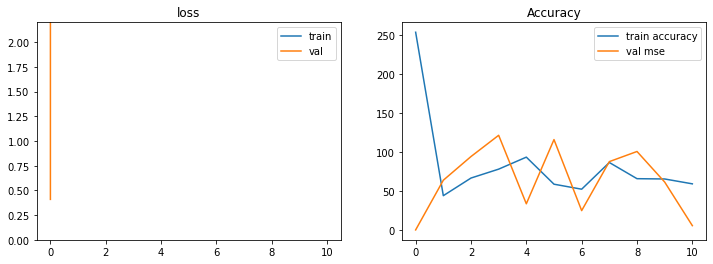

In [243]:
plot_history(history)